In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from random import choice
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

---
Example of Time Series Modelling
=====
***

####Going to use Ebola Deaths as an example

In [2]:
df = pd.DataFrame.from_csv('https://raw.githubusercontent.com/cmrivers/ebola/master/country_timeseries.csv',\
                           index_col=0)

In [3]:
df.columns

Index([u'Day', u'Cases_Guinea', u'Cases_Liberia', u'Cases_SierraLeone',
       u'Cases_Nigeria', u'Cases_Senegal', u'Cases_UnitedStates',
       u'Cases_Spain', u'Cases_Mali', u'Deaths_Guinea', u'Deaths_Liberia',
       u'Deaths_SierraLeone', u'Deaths_Nigeria', u'Deaths_Senegal',
       u'Deaths_UnitedStates', u'Deaths_Spain', u'Deaths_Mali'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122 entries, 2015-01-05 to 2014-03-22
Data columns (total 17 columns):
Day                    122 non-null int64
Cases_Guinea           93 non-null float64
Cases_Liberia          83 non-null float64
Cases_SierraLeone      87 non-null float64
Cases_Nigeria          38 non-null float64
Cases_Senegal          25 non-null float64
Cases_UnitedStates     18 non-null float64
Cases_Spain            16 non-null float64
Cases_Mali             12 non-null float64
Deaths_Guinea          92 non-null float64
Deaths_Liberia         81 non-null float64
Deaths_SierraLeone     87 non-null float64
Deaths_Nigeria         38 non-null float64
Deaths_Senegal         22 non-null float64
Deaths_UnitedStates    18 non-null float64
Deaths_Spain           16 non-null float64
Deaths_Mali            12 non-null float64
dtypes: float64(16), int64(1)
memory usage: 17.2 KB


####We need to impute missing data values, in order to preserve as much of the time series as possible

###Look at "both" ends of this data

In [5]:
deathColList = ["Deaths_Guinea", "Deaths_Liberia", "Deaths_SierraLeone"]

df.sort("Day", ascending=False)[deathColList][1:2]

,Deaths_Guinea,Deaths_Liberia,Deaths_SierraLeone
Date,,,
2015-01-04,1781,NaN,2943


In [6]:
df.sort("Day", ascending=True)[deathColList][1:2]

,Deaths_Guinea,Deaths_Liberia,Deaths_SierraLeone
Date,,,
2014-03-24,59,NaN,NaN


##### Use both a backfill AND a forward fill in order to fill all the NAs. 

In [7]:
df1 = df.bfill()
df1 = df1.ffill()

In [8]:
df1.sort("Day", ascending=False)[deathColList][1:2]

,Deaths_Guinea,Deaths_Liberia,Deaths_SierraLeone
Date,,,
2015-01-04,1781,3496,2943


In [9]:
df1.sort("Day", ascending=True)[deathColList][1:2]

,Deaths_Guinea,Deaths_Liberia,Deaths_SierraLeone
Date,,,
2014-03-24,59,6,5


In [10]:
deaths_df = df1[deathColList]

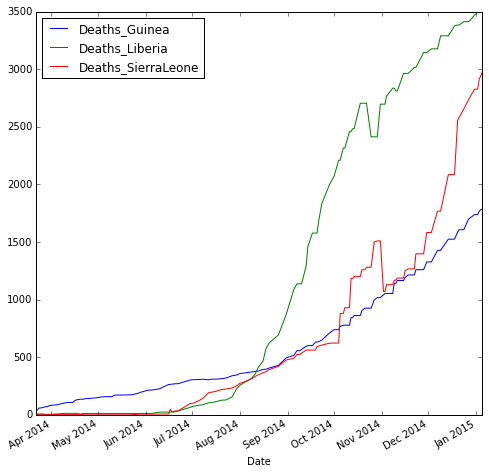

In [12]:
deaths_df.plot(figsize=(8,8))

####The following cell illustrates basic time series modelling
####It's a good start to get your head round what's going on, in terms of lagging columns
####The data has only a single column
####You lag this column by 1 time value to create a new column
####Your Auto-regressive model size determines how many lagged columns you create
####Then you build your model using the rows of all the lagged columns

In [14]:
colList = deaths_df.columns

#For example purposes just try and predict the deaths for the first country in the column list
#So the data just has a single column of data
cols = colList[0]

#For convenience set the deaths column to y
y = deaths_df[cols]

#We use the first half of the data to train on
#This is not ideal - you really want to use a fixed size moving window to train on as you time series progresses
#However, this is not a bad place to start!
train_end = len(y)/2
print "training location end is {:d}".format(train_end)

print "So the first 5 rows of data that we will be predicting are:"
print "--------------------------------"
print y[train_end: train_end + 5]
print "--------------------------------\n"

#ar_size represents the size of your Auto-regressive model
#so if your model size is 4 then use x1 (at time t-4), x2 (at time t-3), x3 (at time t-2), x4 (at time t-1)
#to predict x5 (the current value)

ar_size = 4
    
#Obviously you need to lag your column by 1, up to ar_size in order to get your training data
#You get as many columns as you need because of ar_size
lagged = pd.concat([y.shift(i+1) for i in xrange(0, ar_size)], axis=1)

print "here are the first 10 rows of the lagged data"
print "ar_size if 4 so you have 4 columns, each lagged by 1"
print "clearly you can't use the first ar_size rows because as you lag you create NaNs"
print "--------------------------------"
print lagged[0:10], "\n\n"
print "--------------------------------\n"
    
#The training set will consist of all the lagged columns and the first half of the rows
#Here's your X and y for the model:
X = lagged.ix[ar_size:train_end]
yy = y.ix[ar_size:train_end]
    
#Look at the five rows of the training set and test set
#See what pd.shift is doing
print "--------------------------------"
print "Build a model using these values: ",
for m in xrange(5):
    for k in xrange(ar_size - 1, -1, -1):
        print X.ix[m][k],
    print "to predict this value: ",
    print yy[m],
    print "and"
print "--------------------------------\n"


#Now fit your model    
clf = make_pipeline(PolynomialFeatures(degree=3, interaction_only=False), LinearRegression(fit_intercept=True))
clf.fit(X, yy)
    
predictions = []
#Now use the model to predict the second half of the data
print "--------------------------------"
print "Predicted        Actual"
for t in xrange(train_end, len(y)):
    y_hat = clf.predict(lagged.ix[t])
    print "{:11.2f} {:11.2f}".format(y_hat[0], y.ix[t])

training location end is 61
So the first 5 rows of data that we will be predicting are:
--------------------------------
Date
2014-08-18    396
2014-08-16    394
2014-08-13    380
2014-08-11    377
2014-08-09    373
Name: Deaths_Guinea, dtype: float64
--------------------------------

here are the first 10 rows of the lagged data
ar_size if 4 so you have 4 columns, each lagged by 1
clearly you can't use the first ar_size rows because as you lag you create NaNs
--------------------------------
            Deaths_Guinea  Deaths_Guinea  Deaths_Guinea  Deaths_Guinea
Date                                                                  
2015-01-05            NaN            NaN            NaN            NaN
2015-01-04           1786            NaN            NaN            NaN
2015-01-03           1781           1786            NaN            NaN
2015-01-02           1767           1781           1786            NaN
2014-12-31           1739           1767           1781           1786
2014-

#####Really need to optimize the number of training vectors required and then utilize a moving window
#####This is particularly noticeable for this data which is rapidly changing. 
#####So older data will be less relevant and useful to predict the next data point
#####A moving window would allow the model to train optimally as the time series progresses, dropping old data off the back of the window as new data becomes available at the front of the window